In [1]:
# those modules are almost always imported when working with model data
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr # the major tool to work with NetCDF data!

import netCDF4
import os
from glob import glob
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import pickle as pickle

## First load Gravity CSV for sampling

In [2]:
import pandas as pd
from glob import glob
def importOIBgrav(basedir, timedir):
    # datadir = 'IGGRV1B/temp'
    # infile = 'IGGRV1B_20091104_13100500_V016'
    # infile = 'IGGRV1B_20091031_11020500_V016'
    # infile = 'IGGRV1B_20091116_15124500_V016'
    suffix = '.txt'
    pattern = os.path.join(basedir, timedir, 'IGGRV1B_20161114_11243000_V017*' + suffix)
    infile = sorted(glob(pattern))  # , key=alphanum_key)

    ### Read ascii file as csv
    # metadata ends on line 69, column names on line 70
    headers = (
        'LAT', 'LONG', 'DATE', 'DOY', 'TIME', 'FLT', 'PSX', 'PSY', 'WGSHGT', 'FX', 'FY', 'FZ', 'EOTGRAV', 'FACOR',
        'INTCOR',
        'FAG070', 'FAG100', 'FAG140', 'FLTENVIRO')
    # print "Reading gravity file: %s" % infile[0] + suffix %TODO why did I think this would be a list?
    print("Reading gravity file: %s" % infile[0] + suffix)
    df = pd.read_csv(infile[0], delimiter=r"\s+", header=None, names=headers, skiprows=70)
    # headers = df.columns[1:df.shape[1]]
    # df.rename(columns=dict(zip(df.columns,headers)), inplace=True)
    # df.rename(columns={'LONG': 'LON'}, inplace=True)
    # df['ENVIRO'] = df.columns[[19]]
    # df.drop(df.columns['FLTENVIRO'],axis=1,inplace=True)

    ### do some DATETIME operations
    df['DATETIME'] = (df.DATE * 1e5) + df.TIME
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
    df['UNIX'] = df['DATE'].astype(np.int64) // 10 ** 9
    df['UNIX'] = df['UNIX'] + df['TIME']
    df['iunix'] = pd.to_datetime(df['UNIX'] * 10 ** 3, unit='ms')
    df.drop(['DATETIME'], axis=1, inplace=True)
    df = df.set_index('iunix')
    return df

basedir = '/Users/dporter/Documents/data_local/Antarctica/OIB/'
datadir = 'IGGRV1B'
timedir = 2016
grav = importOIBgrav(os.path.join(basedir, datadir), str(timedir))


Reading gravity file: /Users/dporter/Documents/data_local/Antarctica/OIB/IGGRV1B/2016/IGGRV1B_20161114_11243000_V017.txt.txt


In [3]:
grav.head()

,LAT,LONG,DATE,DOY,TIME,FLT,PSX,PSY,WGSHGT,FX,FY,FZ,EOTGRAV,FACOR,INTCOR,FAG070,FAG100,FAG140,FLTENVIRO,UNIX
iunix,,,,,,,,,,,,,,,,,,,,
2016-11-14 11:24:30.000,-53.004590,-70.845986,2016-11-14,319,41070.0,621,-3929452.26,1364844.81,50.57,5.01,-15.79,981296.93,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:30.500,-53.004590,-70.845986,2016-11-14,319,41070.5,621,-3929452.26,1364844.81,50.57,4.52,-15.33,981297.13,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:31.000,-53.004590,-70.845985,2016-11-14,319,41071.0,621,-3929452.27,1364844.82,50.56,3.46,-14.49,981297.14,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:31.500,-53.004590,-70.845985,2016-11-14,319,41071.5,621,-3929452.27,1364844.83,50.55,2.05,-13.60,981296.95,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:32.000,-53.004589,-70.845985,2016-11-14,319,41072.0,621,-3929452.28,1364844.85,50.54,0.73,-13.01,981296.61,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09


## BEDMAP tiff

In [200]:
import os
from osgeo import gdal, osr

# import geopandas
# from cartopy import crs as ccrs

# help(gdal)

ds = gdal.Open('/Users/dporter/Documents/Research/Projects/Quantarctica3/TerrainModels/BEDMAP2/bedmap2_bed.tif')

In [201]:
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

print(inproj)

PROJCS["WGS 84 / Antarctic Polar Stereographic",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",-71],
    PARAMETER["central_meridian",0],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","3031"]]


In [202]:
import cartopy.crs as ccrs


projcs = inproj.GetAuthorityCode('PROJCS')
projection = ccrs.epsg(projcs)
print(projection)

_EPSGProjection(3031)


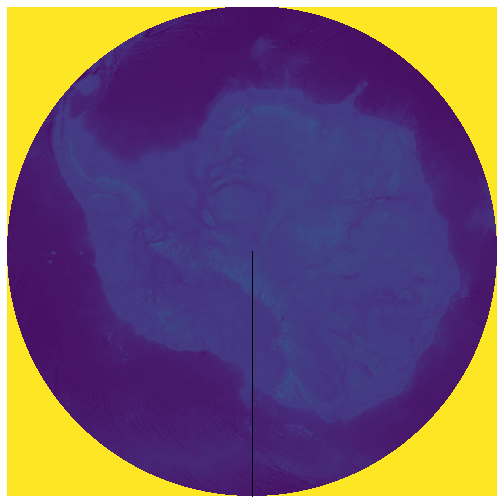

In [203]:
import matplotlib.pyplot as plt

subplot_kw = dict(projection=projection)
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=subplot_kw)

extent = (gt[0], gt[0] + ds.RasterXSize * gt[1],
          gt[3] + ds.RasterYSize * gt[5], gt[3])

img = ax.imshow(data, extent=extent,
                origin='upper')

In [204]:
data

array([[32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       ...,
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767]], dtype=int16)

### Rasterstats to SAMPLE GRID?

In [109]:
from rasterstats import point_query, zonal_stats

rasterfile = '/Users/dporter/Documents/Research/Projects/Quantarctica3/Geophysics/ANTGG/ANTGG_FreeAirGravityAnomaly_10km.tif'
# pointfile = '/Users/dporter/Documents/Research/Projects/ROSETTA/data/ROSETTA_Grid_Flown_ln.shp'
pointfile = '/Users/dporter/Documents/Research/Projects/OIB-grav/data/OIB_2009-10-28_3031.shp'


In [135]:
import time
start_sample = time.time()

stats = point_query(pointfile, rasterfile, interpolate='nearest', geojson_out=False)
# stats = zonal_stats(pointfile, rasterfile)

end_sample = time.time()
print(('Sampling took {} sec'.format(end_sample - start_sample)))

Sampling took 178.78824710845947 sec


In [137]:
start_sample = time.time()

stats = point_query(pointfile, rasterfile, interpolate='bilinear', geojson_out=False)
# stats = zonal_stats(pointfile, rasterfile)

end_sample = time.time()
print(('Sampling took {} sec'.format(end_sample - start_sample)))

Sampling took 200.8282470703125 sec


In [136]:
start_sample = time.time()

# GEOJSON
stats_json = point_query(pointfile, rasterfile, interpolate='nearest', property_name='FAA', geojson_out=True)

end_sample = time.time()
print(('Sampling took {} sec'.format(end_sample - start_sample)))

Sampling took 197.91501903533936 sec


In [139]:
from pprint import pprint
pprint(stats)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [138]:
# np.array(stats)

# Debug

In [7]:
from shapely import speedups;

assert speedups.available;

speedups.enable()

from shapely.geometry import LineString

ls = LineString([(0, 0), (10, 0)])
# On OSX causes an abort trap, due to https://github.com/Toblerity/Shapely/issues/177 
r = ls.wkt
area = ls.buffer(10).area

In [8]:
area

513.6548490545939